In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings("ignore")

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the images to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the data generator to the training data
datagen.fit(x_train.reshape(-1, 28, 28, 1))


In [5]:
# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=32), epochs=10, validation_data=(x_test.reshape(-1, 28, 28, 1), y_test))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7669 - loss: 0.7067 - val_accuracy: 0.9853 - val_loss: 0.0485
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9451 - loss: 0.1868 - val_accuracy: 0.9888 - val_loss: 0.0308
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9615 - loss: 0.1308 - val_accuracy: 0.9920 - val_loss: 0.0251
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9680 - loss: 0.1075 - val_accuracy: 0.9915 - val_loss: 0.0262
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9728 - loss: 0.0922 - val_accuracy: 0.9914 - val_loss: 0.0271
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9762 - loss: 0.0826 - val_accuracy: 0.9925 - val_loss: 0.0249
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9794 - loss: 0.0721 - val_accuracy: 0.9926 - val_loss: 0.0242
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9802 -

In [3]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='mnist_tuning',
                     project_name='mnist')

tuner.search(x_train.reshape(-1, 28, 28, 1), y_train, epochs=10, validation_data=(x_test.reshape(-1, 28, 28, 1), y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('dense_units')} 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Reloading Tuner from mnist_tuning\mnist\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 64 
and the optimal learning rate for the optimizer is 0.001.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,194 (551.54 KB)

 Trainable params: 140,938 (550.54 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.8186 - loss: 0.5635 - val_accuracy: 0.9774 - val_loss: 0.0710
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9518 - loss: 0.1608 - val_accuracy: 0.9846 - val_loss: 0.0474
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9642 - loss: 0.1230 - val_accuracy: 0.9864 - val_loss: 0.0451
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9700 - loss: 0.1023 - val_accuracy: 0.9883 - val_loss: 0.0361
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9722 - loss: 0.0928 - val_accuracy: 0.9916 - val_loss: 0.0281
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9749 - loss: 0.0884 - val_accuracy: 0.9868 - val_loss: 0.0461
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9769 - loss: 0.0830 - val_accuracy: 0.9935 - val_loss: 0.0242
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9779 -

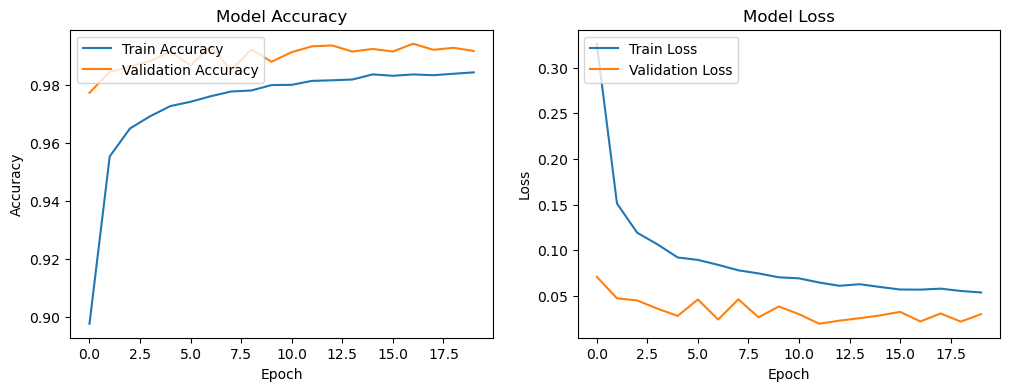

In [4]:
# Optimal hyperparameters from the search
optimal_dense_units = 64
optimal_learning_rate = 0.001

# Build and compile the model with optimal hyperparameters
def build_optimized_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(optimal_dense_units, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=optimal_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

optimized_model = build_optimized_model()
optimized_model.summary()

# Train the model
history = optimized_model.fit(datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=32), 
                              epochs=20, 
                              validation_data=(x_test.reshape(-1, 28, 28, 1), y_test))

# Evaluate the model
test_loss, test_acc = optimized_model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
print(f'\nTest accuracy: {test_acc}')

# Predictions
y_pred = optimized_model.predict(x_test.reshape(-1, 28, 28, 1))
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_classes))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [12]:
# Save the entire model as an HDF5 file.
model_save_path = 'optimized_mnist_model.h5'
tf.keras.models.save_model(optimized_model, model_save_path, save_format='h5')
print(f'Model saved to {model_save_path}')


Model saved to optimized_mnist_model.h5
